In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
from fastai2.vision.all import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset

from htools import *

In [3]:
cd_root()

Current directory: /Users/hmamin/img_wang


In [33]:
dir_ = Path('data/imagewang-160/')
path_u = dir_/'unsup'

In [34]:
files_u = get_image_files(path_u)
len(files_u)

7750

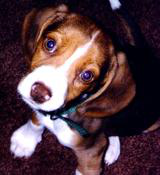

In [35]:
load_image(files_u[1])

In [36]:
WangBlock = DataBlock(blocks=([ImageBlock]*4),
                      splitter=(),
                      get_items=get_image_files,
                      splitter=GrandparentSplitter(), 
                      item_tfms=Resize(160))

In [37]:
bs = 4
db = WangBlock.dataloaders(path_u, bs=bs)

In [38]:
attrmap('shape', *db.one_batch())

[torch.Size([4, 3, 160, 160]),
 torch.Size([4, 3, 160, 160]),
 torch.Size([4, 3, 160, 160]),
 torch.Size([4, 3, 160, 160])]

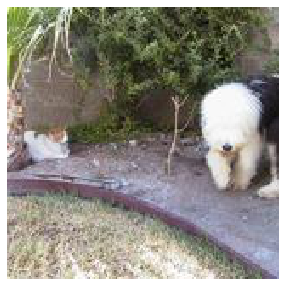

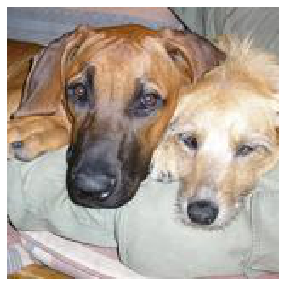

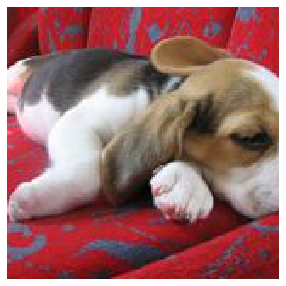

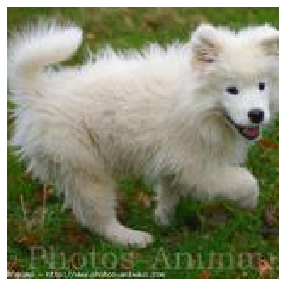

In [39]:
db.show_batch()

In [41]:
db.valid_ds

(#1550) [(PILImage mode=RGB size=160x225, PILImage mode=RGB size=160x225, PILImage mode=RGB size=160x225, PILImage mode=RGB size=160x225),(PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160),(PILImage mode=RGB size=239x160, PILImage mode=RGB size=239x160, PILImage mode=RGB size=239x160, PILImage mode=RGB size=239x160),(PILImage mode=RGB size=160x240, PILImage mode=RGB size=160x240, PILImage mode=RGB size=160x240, PILImage mode=RGB size=160x240),(PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160),(PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160),(PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160, PILImage mode=RGB size=213x160),(PILImage mode=RGB size=160x239, PILImage mode=RGB size=160x239, PILImage mode=RGB size=

In [62]:
class ImageMixTransform(Transform):
    
    def __init__(self, files):
        self.files = files
    
    def encodes(self, i):
        files = self.files[i:i+3]
        return tuple(map(load_image, files))
    
    def show(self, ctx=None, **kwargs):
        pass

In [63]:
ttl = TfmdLists(range(len(files_u)), ImageMixTransform(files_u))

In [64]:
x, y, z = ttl[0]

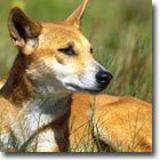

In [67]:
x

In [86]:
x = np.random.randint(5, size=4)
x / x.sum()

array([0.27272727, 0.27272727, 0.27272727, 0.18181818])

In [227]:
def rand_weights(a=5, b=8):
#     x = torch.randn(size)
#     return torch.softmax(x, dim=-1)
#     dist = torch.distributions.dirichlet.Dirichlet(torch.tensor([1/size] * size))
#     dist = torch.distributions.dirichlet.Dirichlet(torch.tensor([40., 10., 1.]))
    dist = torch.distributions.beta.Beta(a, b)
    return dist.sample()

In [228]:
w = [rand_weights() for _ in range(1_000)]

(0, 1)

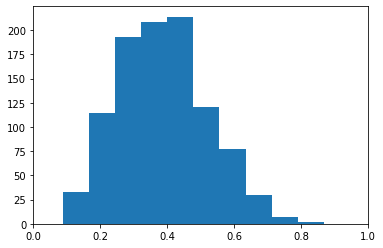

In [229]:
plt.hist(w)
plt.xlim(0, 1)

In [215]:
plt.hist([n for row in w for n in row])
plt.show()

TypeError: iteration over a 0-d tensor

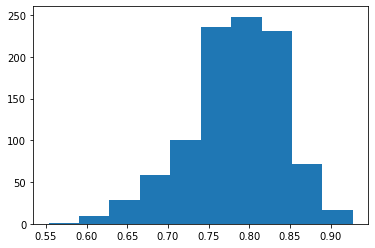

In [210]:
plt.hist([max(row) for row in w])
plt.show()

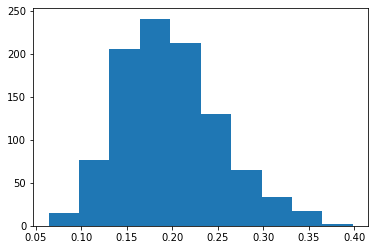

In [212]:
plt.hist([np.median(row) for row in w])
plt.show()

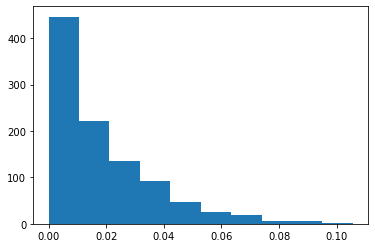

In [211]:
plt.hist([min(row) for row in w])
plt.show()

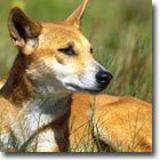

In [336]:
Image.open(files_u[0])

In [452]:
class ImageMixer:
    
    def __init__(self, n=3, dist=None):
        self.dist = dist or torch.distributions.beta.Beta(5, 8)
        self.n = n
        
    def transform(self, *images):
        w = self._generate_weights()
        print(w)
        return (self._combine_images(images, w), *images)
        
    def _generate_weights(self):
        weights = np.zeros(self.n)
        p = self.dist.sample()
        indices = np.random.choice(self.n, size=2, replace=False)
        weights[indices] = p, 1-p
        return torch.tensor(weights)
    
    def _combine_images(self, images, weights):
#         img*w for img, w in zip(images, weights)
        images = torch.stack(images, dim=0)
#         return weights[(None,) * (images.dim()-1)]
        return (weights[:, None, None, None] * images).sum(0)
#         return (weights[(None,) * (images.dim()-1)].transpose(-1, 0) * images).sum(0)

In [453]:
xb = db.one_batch()
a, b, c, d = xb[0]
a.shape

torch.Size([3, 160, 160])

In [454]:
torch.tensor([0.85448831, 0., 0.14551167])[(None,)*3].transpose(-1, 0).shape

torch.Size([3, 1, 1, 1])

In [462]:
mixer = ImageMixer()
res = mixer.transform(a, b, c)

tensor([0.0000, 0.4087, 0.5913], dtype=torch.float64)


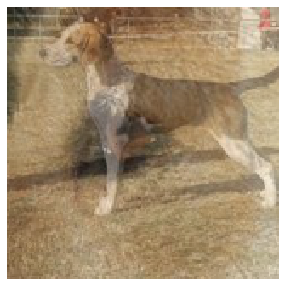

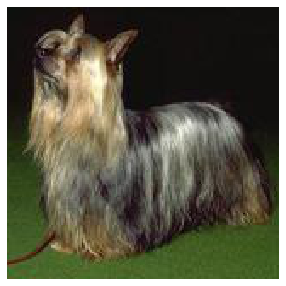

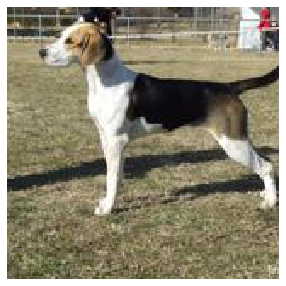

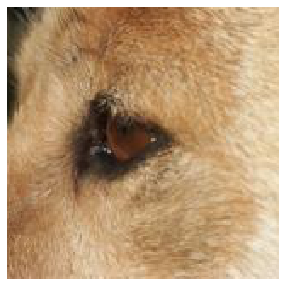

In [463]:
for img in res:
    show_image(img)

In [267]:
img = torch.randint(0, 4, (2, 3, 4, 4))
img

tensor([[[[0, 3, 3, 3],
          [2, 2, 2, 3],
          [3, 0, 2, 2],
          [1, 0, 0, 3]],

         [[3, 3, 3, 2],
          [2, 0, 0, 1],
          [0, 0, 1, 3],
          [0, 2, 2, 3]],

         [[0, 0, 1, 2],
          [2, 2, 3, 2],
          [1, 1, 3, 1],
          [3, 2, 0, 1]]],


        [[[2, 1, 1, 1],
          [3, 0, 0, 2],
          [2, 3, 2, 0],
          [1, 1, 3, 1]],

         [[1, 1, 3, 2],
          [0, 2, 1, 0],
          [3, 2, 1, 1],
          [2, 0, 0, 1]],

         [[0, 3, 0, 1],
          [0, 1, 0, 0],
          [1, 2, 1, 3],
          [0, 1, 1, 0]]]])

In [279]:
w = torch.tensor([2, 3])
w

tensor([2, 3])

In [306]:
w[(None,)*3].transpose(-1, 0)

torch.Size([2, 1, 1, 1])

In [280]:
w[:, None, None, None] * img

tensor([[[[0, 6, 6, 6],
          [4, 4, 4, 6],
          [6, 0, 4, 4],
          [2, 0, 0, 6]],

         [[6, 6, 6, 4],
          [4, 0, 0, 2],
          [0, 0, 2, 6],
          [0, 4, 4, 6]],

         [[0, 0, 2, 4],
          [4, 4, 6, 4],
          [2, 2, 6, 2],
          [6, 4, 0, 2]]],


        [[[6, 3, 3, 3],
          [9, 0, 0, 6],
          [6, 9, 6, 0],
          [3, 3, 9, 3]],

         [[3, 3, 9, 6],
          [0, 6, 3, 0],
          [9, 6, 3, 3],
          [6, 0, 0, 3]],

         [[0, 9, 0, 3],
          [0, 3, 0, 0],
          [3, 6, 3, 9],
          [0, 3, 3, 0]]]])

In [509]:
class MixupDS(Dataset):
    
    def __init__(self, paths, size=160, n=3, dist=None):
        self.paths = paths
        self.resizer = Resize(size)
        self.n = n
        self.mixer = ImageMixer(n=3, dist=None) # Require defaults for now while functionality is narrow.
        
    def __len__(self):
        return len(self.paths) // self.n
    
    def __getitem__(self, i):
        images = (self.resizer.encodes(self._load_img(p))
                  for p in self.paths[i:i+self.n])
        return images
#         return self.mixer.transform(*images)

    def _load_img(self, path):
        img = load_image(path)
        return TensorImage(img) / 255.

In [510]:
ds = MixupDS(files_u)
len(ds)

2583

In [511]:
res = list(ds[0])

In [512]:
res[1].shape

torch.Size([175, 160, 3])

In [490]:
ds.resizer.encodes(res[1]).shape

torch.Size([175, 160, 3])

In [471]:
for i in range(5):
    _ = ds[i]

tensor([0.7390, 0.0000, 0.2610], dtype=torch.float64)


RuntimeError: stack expects each tensor to be equal size, but got [160, 160, 3] at entry 0 and [175, 160, 3] at entry 1

In [252]:
xb[-1]

array([0.        , 0.55218738, 0.44781262])

In [502]:
ds.resizer.encodes(res[2]).shape

torch.Size([160, 181, 3])

In [501]:
res[2].shape

torch.Size([160, 181, 3])

In [500]:
ds.resizer.size

(160, 160)